In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
from sklearn.model_selection import train_test_split

# Data

In [2]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv', 'rb'), delimiter = ',')

labels = data[:,0]
data = data[:, 1:]

labels = torch.tensor(labels, dtype = torch.long)
data = torch.tensor(data, dtype = torch.float)
data_norm = data / torch.max(data)

labels, data_norm

(tensor([6, 5, 7,  ..., 2, 9, 5]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

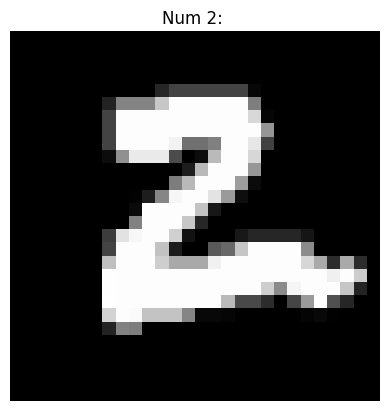

In [3]:
rand_row = np.random.randint(data.shape[0])
img = np.reshape(data_norm[rand_row], (28,28))
num = labels[rand_row]

plt.imshow(img, cmap = 'grey')
plt.title('Num %d: '%num)
plt.axis(False)
plt.show()

# Scramble the imgaes

In [4]:
np.random.permutation(100)

array([83,  5, 58, 63, 87, 68, 74, 45, 52, 90,  8, 97, 53, 96, 26, 64, 84,
       42, 44, 18, 28, 69, 33, 39, 34, 66, 73, 41, 25, 93, 86, 24, 82, 65,
        9, 95, 16, 56, 91, 77, 94, 60,  1, 54, 49, 99, 29, 76, 30, 37,  6,
       75, 32, 10, 79, 89, 98, 92,  3, 57, 61, 59, 27, 43,  4, 50,  7, 48,
       38,  0, 40, 80, 15, 23, 51, 21, 17, 22, 85, 78, 36, 35, 55, 67, 81,
       47, 20, 14, 71, 72, 88, 13, 19,  2, 70, 12, 11, 46, 31, 62])

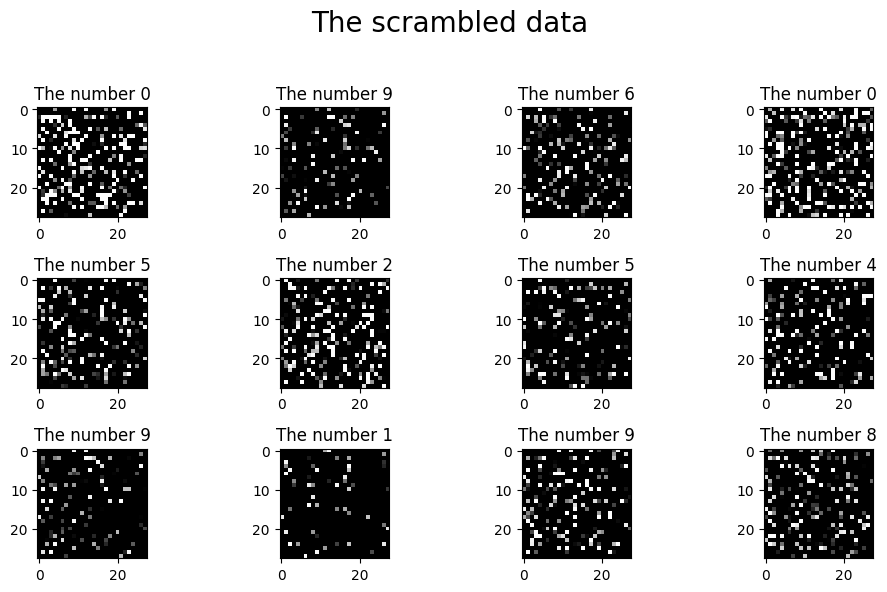

In [9]:
# randomly scramble the data
# preserving the re-ordering for each image
eggs = np.random.permutation(data.shape[1])
scrambled = data_norm[:,eggs]

fig, axs = plt.subplots(3,4,figsize = (10,6))

for ax in axs.flatten():
  rand_img = np.random.randint(0, high = data.shape[0])

  img = np.reshape(scrambled[rand_img,:], (28,28))
  ax.imshow(img, cmap = 'grey')

  ax.set_title('The number %i'%labels[rand_img])

plt.suptitle('The scrambled data', fontsize = 20)
plt.tight_layout(rect = [0,0,1,.95])
plt.show()

# Split

In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(scrambled, labels, test_size = .2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = test_data.shape[0])

# Model

In [11]:
def ModelCreate(n_layers, n_units):

  class ModelArch(nn.Module):
    def __init__(self, n_layers, n_units):
      super().__init__()

      self.n_layers = n_layers
      self.layers = nn.ModuleDict()

      # Layers
      self.layers['input'] = nn.Linear(784, n_units)

      for i in range(n_layers):
        self.layers[f'hidden_{i}'] = nn.Linear(n_units, n_units)

      self.layers['output'] = nn.Linear(n_units, 10)

    def forward(self, x):
      x = self.layers['input'](x)

      for i in range(self.n_layers):
        x = self.layers[f'hidden_{i}'](x)

      x = self.layers['output'](x)

      return x

  ann = ModelArch(n_layers, n_units)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 1e-2)

  return ann, loss_fn, optimizer

In [12]:
ann, loss_fn, optimizer = ModelCreate(n_layers = 2, n_units = 64)
X, y = next(iter(train_dataloader))
y_hat = ann(X)
loss = loss_fn(y_hat, y)
loss

tensor(2.3154, grad_fn=<NllLossBackward0>)

# Train

In [16]:
def ModelTrain(epochs, n_layers, n_units, verbose):
  net, loss_fn, optimizer = ModelCreate(n_layers, n_units)

  losses = torch.zeros(epochs)
  train_accs = []
  test_accs = []

  for epoch in range(epochs):
    net.train()

    batch_acc = []
    batch_loss = []

    for X, y in train_dataloader:

      y_hat = net(X)
      loss = loss_fn(y_hat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis = 1) == y
      matches_numeric = matches.float()
      accuracy_pct = 100 * torch.mean(matches_numeric)
      batch_acc.append(accuracy_pct)
    # end of batch loop

    #training accuracy
    train_acc = np.mean(batch_acc)
    train_accs.append(train_acc)

    # and get  avg losses
    losses[epoch] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(test_dataloader))
    with torch.no_grad(): # deactivates autograd
      y_hat = net(X)

    test_acc = 100 * torch.mean((torch.argmax(y_hat, axis = 1) == y).float())
    test_accs.append(test_acc)
  # end epochs

    if verbose and epoch%10 == 0:
      print(f'Epoch: {epoch} | Train Acc: {train_acc:.2f} | Test Acc: {test_acc:.2f} | Loss: {losses[epoch]:.2f}')

  return train_accs, test_accs, losses

In [17]:
train_accs, test_accs, losses = ModelTrain(epochs = 100, n_layers = 2, n_units = 64, verbose = True)

Epoch: 0 | Train Acc: 32.15 | Test Acc: 51.82 | Loss: 2.21
Epoch: 10 | Train Acc: 89.85 | Test Acc: 89.05 | Loss: 0.36
Epoch: 20 | Train Acc: 91.55 | Test Acc: 90.07 | Loss: 0.30
Epoch: 30 | Train Acc: 92.36 | Test Acc: 90.82 | Loss: 0.27
Epoch: 40 | Train Acc: 92.93 | Test Acc: 90.90 | Loss: 0.25
Epoch: 50 | Train Acc: 93.26 | Test Acc: 91.07 | Loss: 0.24
Epoch: 60 | Train Acc: 93.69 | Test Acc: 91.03 | Loss: 0.23
Epoch: 70 | Train Acc: 93.78 | Test Acc: 91.10 | Loss: 0.22
Epoch: 80 | Train Acc: 93.94 | Test Acc: 90.78 | Loss: 0.21
Epoch: 90 | Train Acc: 94.03 | Test Acc: 91.12 | Loss: 0.21


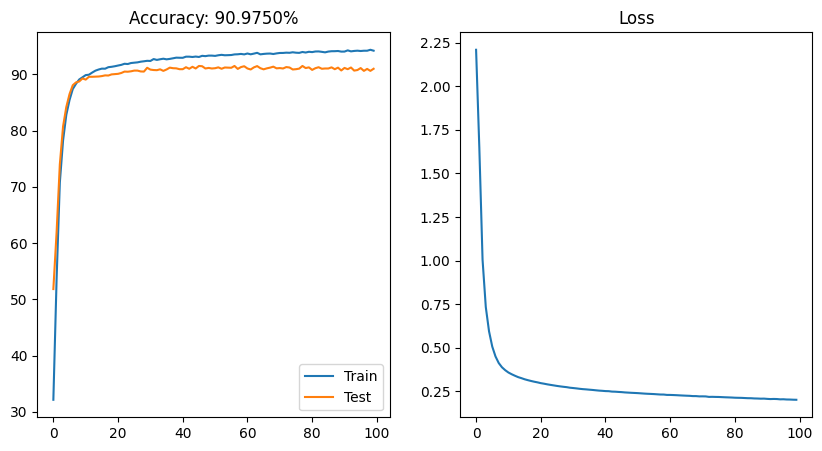

In [22]:
fig, ax = plt.subplots(1,2,figsize = (10,5))

ax[0].plot(train_accs)
ax[0].plot(test_accs)
ax[0].legend(['Train', 'Test'])
ax[0].set_title(f'Accuracy: {test_accs[-1]:.4f}%')

ax[1].plot(losses)
ax[1].set_title('Loss')
plt.show()

Even though we scrambled data, so we shuffled columns our model was able to perform as well as with ordered columns.